<style>div.container { width: 100% }</style>
<img style="float:left;  vertical-align:text-bottom;" height="65" width="172" src="../assets/holoviz-logo-unstacked.svg" />
<div style="float:right; vertical-align:text-bottom;"><h2>Tutorial 6. Dashboards</h2></div>

So far in this tutorial, we have seen how to generate plots with `.plot` or `.hvplot`, how to compose these plots together into layouts and overlays, how to link selections between these plots, and how to control visualizations with Panel widgets using `.interactive`. In this notebook, we will learn how to put all these pieces together to display (and serve) these components in a dashboard using Panel.

## Panel `pane` objects

So far we have only seen Panel used as a source of widgets, but Panel also offers [pane](https://panel.holoviz.org/reference/index.html#panes) objects that can display various types of data (including output from just about any plotting library). First let's import Panel and load the extension:

In [1]:
import pathlib
import pandas as pd
import panel as pn
import xarray as xr
import holoviews as hv

pn.extension('tabulator', template='material', sizing_mode='stretch_width')

import colorcet as cc
import hvplot.xarray # noqa
import hvplot.pandas # noqa

Here, we have enabled some optional functionality from Panel, specifically the `tabulator` extension, and selected a default template controlling the overall look and feel of the final app. We also configured how plots should be sized by default (stretching to fit the width available). We'll come back to the idea of a template later. Here, let's look at a simple pane, e.g. a [Markdown pane](https://panel.holoviz.org/reference/panes/Markdown.html) that displays Markdown-format text:

In [2]:
pn.pane.Markdown('## Earthquake Dashboard')

Markdown(str, sizing_mode='stretch_width')

In [3]:
logo_path = pathlib.Path('../assets/usgs_logo.png')

The `PNG` pane can display PNG images:

PNG(str, height=130, sizing_mode='stretch_width')
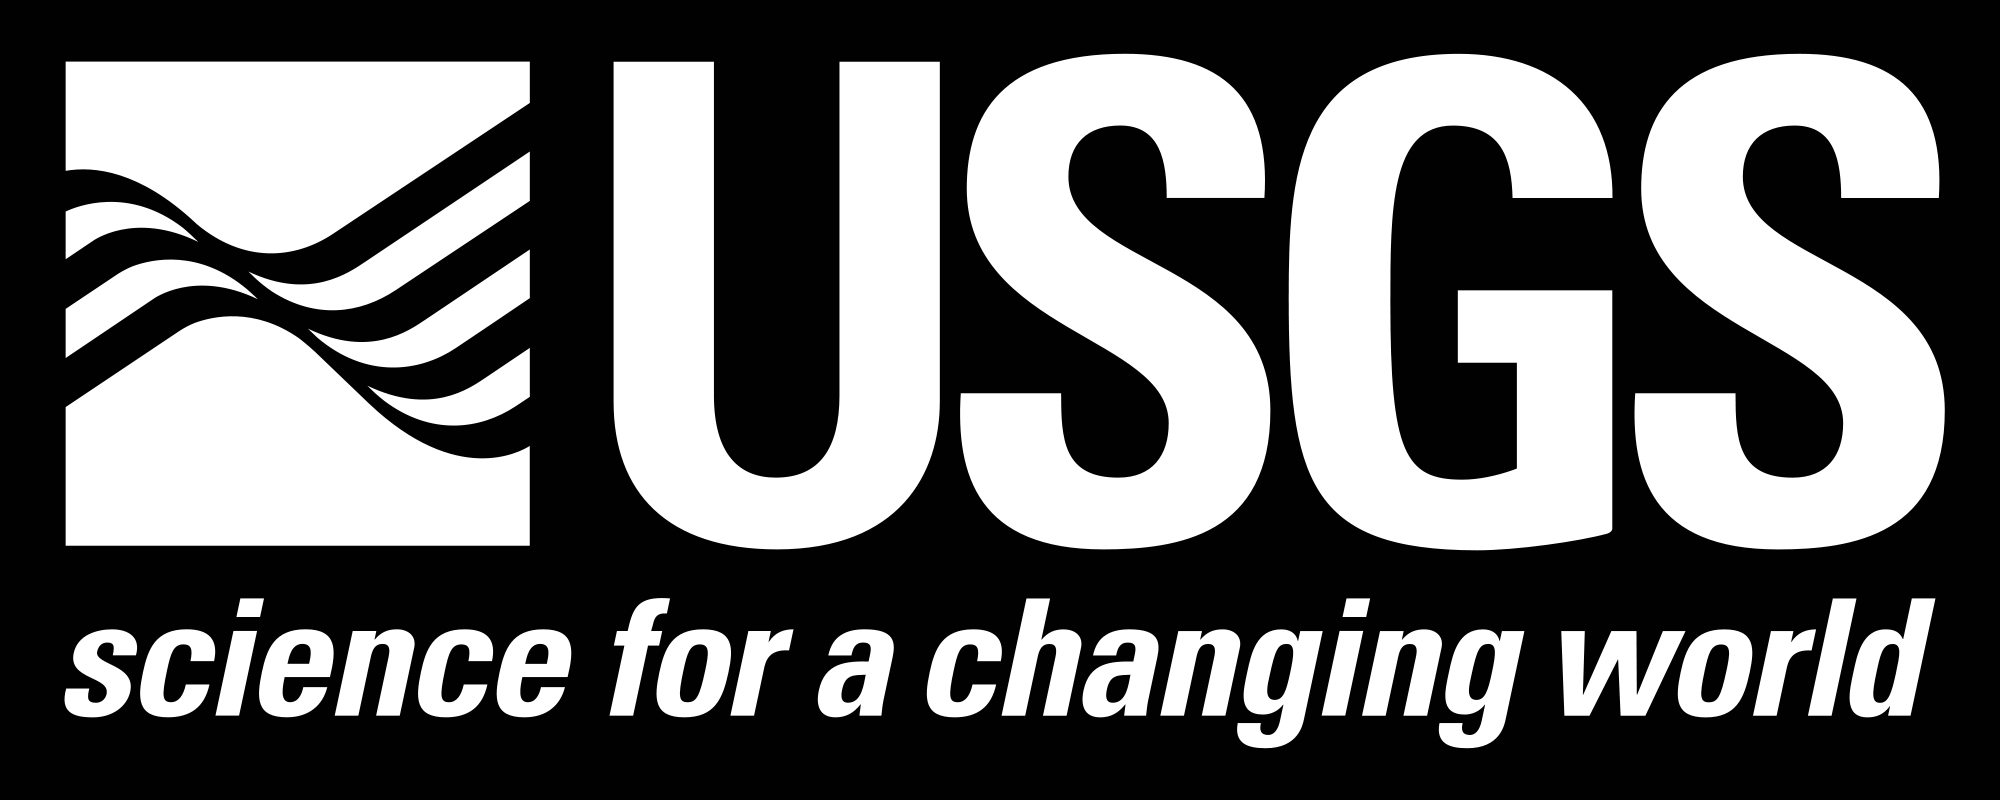

In [4]:
pn.pane.PNG(logo_path, height=130)

## Using `pn.panel`

Instead of having to select the pane type explicitly, you can use the `pn.panel` function that tries to guess the appropriate representation given the input. For instance, here we generate the same two panels using `pn.panel` and grab handles on the resulting objects:

In [5]:
dashboard_title = pn.panel('## Earthquakes')
usgs_logo = pn.panel(logo_path, height=130)

#### Exercise

Confirm that these two objects are of type `Markdown` and `PNG` respectively by using the `type` built-in. Explore using different markdown syntax such as *italic*, **bold** or adding bullet points. Finally, try displaying your own PNG image with a `PNG` pane, using either a local filename or URL.

## `Panel` objects

In addition to `pane` objects, Panel offers containers of type `panel` which allow you to position your components into various layouts. For instance, we can put a small version of our title and logo into a Panel `Row` layout:

Row(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] PNG(str, height=40, sizing_mode='stretch_width')
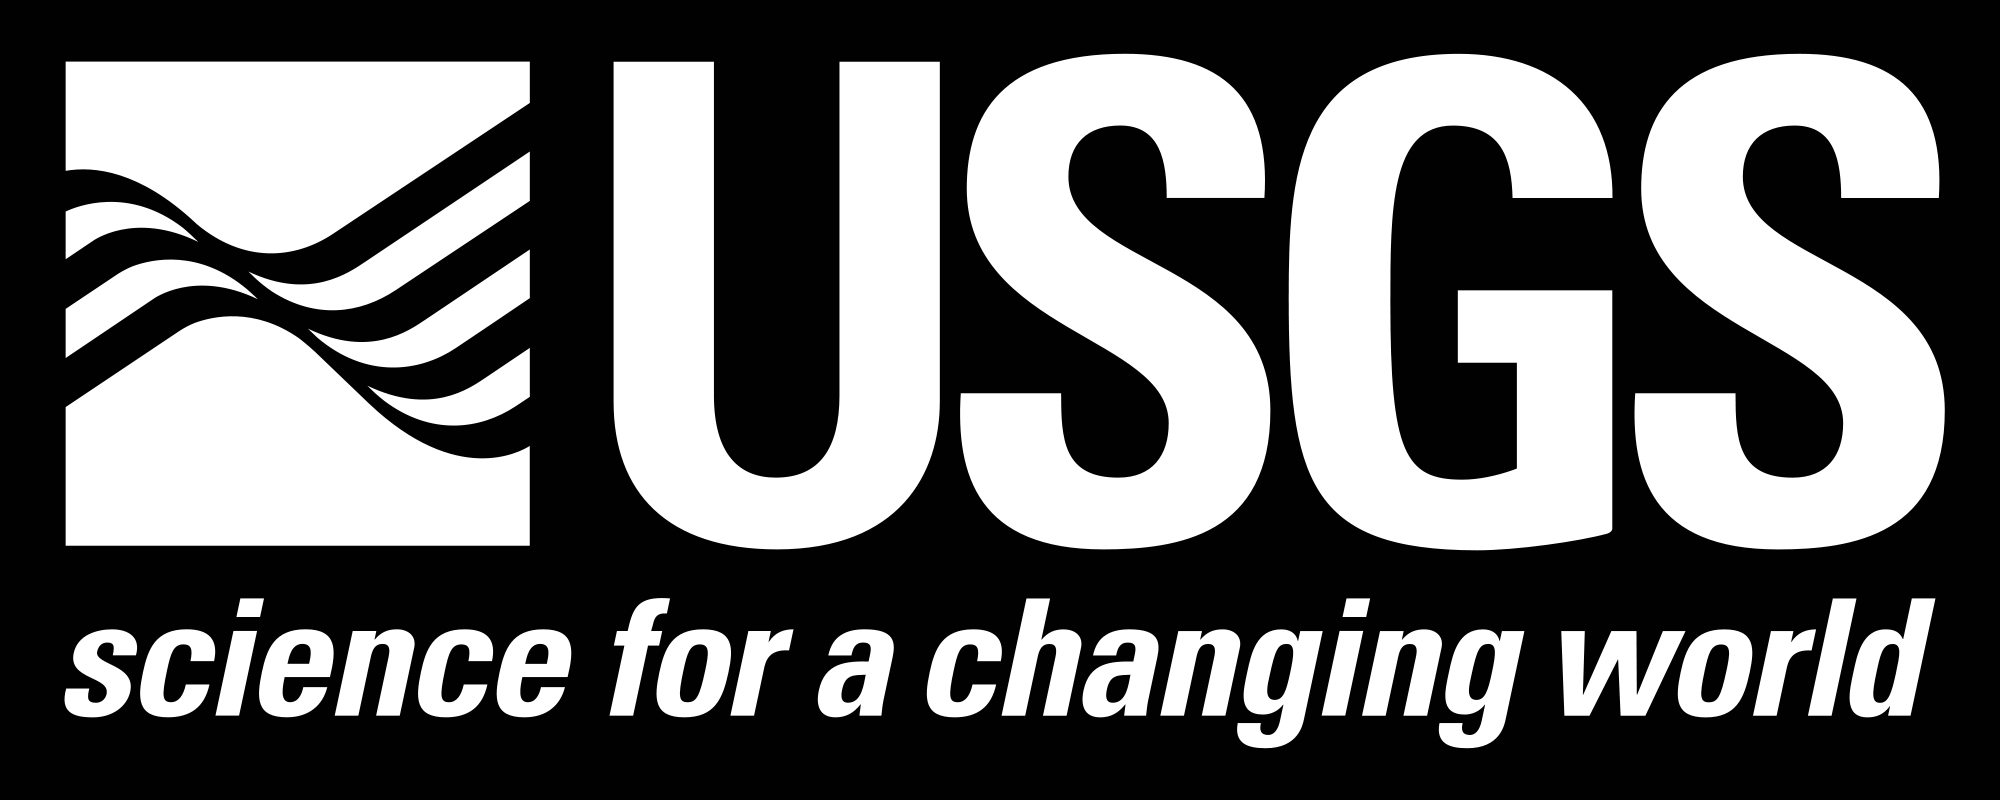

In [6]:
header = pn.Row(dashboard_title, pn.pane.PNG(logo_path, height=40))
header

Next let us load the earthquake dataset and make a basic plot of the sort we have seen earlier on in the tutorial:

In [7]:
%%time
df = pd.read_parquet(pathlib.Path('../data/earthquakes-projected.parq'))
df = df.set_index('time').tz_convert(None).reset_index()
small_df = df.sample(frac=.01)

CPU times: user 1.99 s, sys: 573 ms, total: 2.56 s
Wall time: 2.63 s


In [8]:
%%time
ds = xr.open_dataarray(pathlib.Path('../data/raster/gpw_v4_population_density_rev11_2010_2pt5_min.nc'))
cleaned_ds = ds.where(ds.values != ds.nodatavals).sel(band=1)
cleaned_ds.name = 'population'

CPU times: user 53.2 ms, sys: 50.9 ms, total: 104 ms
Wall time: 151 ms


In [9]:
sample_points = small_df.hvplot.points(x='longitude', y='latitude', c='mag', cmap=cc.CET_L4, responsive=True)
rasterized_pop = cleaned_ds.hvplot.image(rasterize=True, logz=True, clim=(1, None), responsive=True, min_height=400).opts(bgcolor='black')
earthquake_example = rasterized_pop * sample_points

Now we can combine this plot with our header in a `pn.Column`:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Column(sizing_mode='stretch_width')
    [0] Row(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] PNG(str, height=40, sizing_mode='stretch_width')
    [1] HoloViews(DynamicMap, sizing_mode='stretch_width')
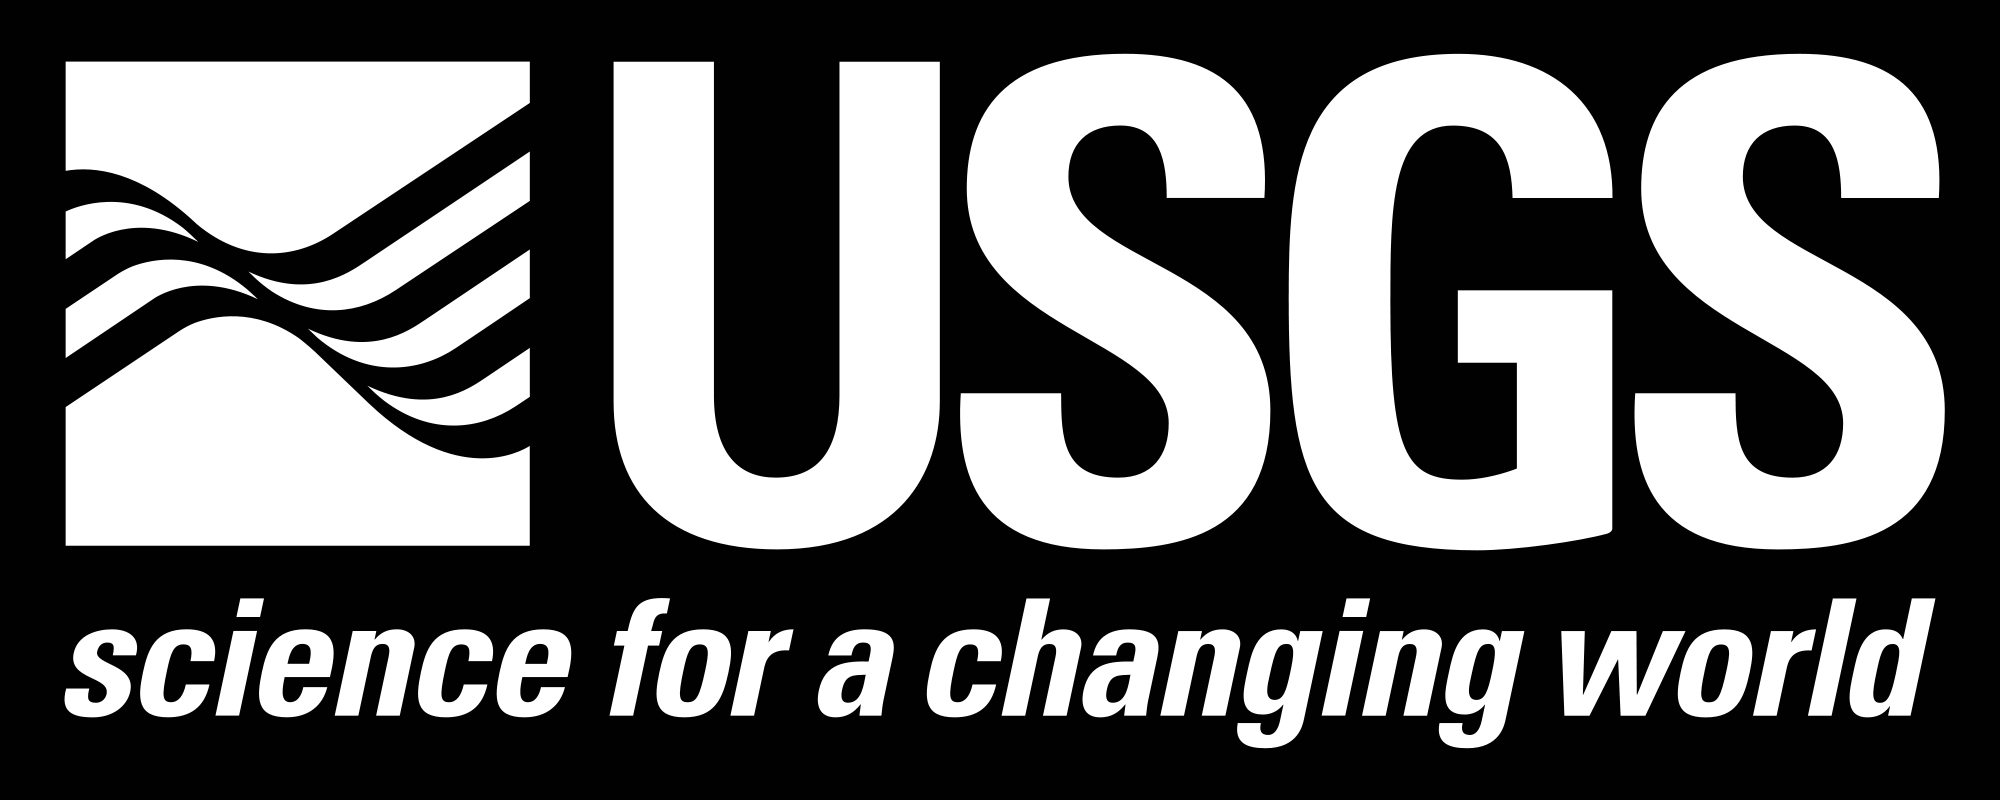

In [10]:
mini_dashboard = pn.Column(header, earthquake_example)
mini_dashboard

## Showing and serving dashboards

Now`mini_dashboard` is a Panel object that can be displayed or served as a simple dashboard. To view the dashboard in a new tab, you can simply call `.show()`:

In [11]:
# mini_dashboard.show()

If instead of `.show()` you use the `.servable()` method, you can serve the dashboard from this notebook using the command:

```bash
$ panel serve 06_Dashboard.ipynb
```

We will use this to serve a more sophisticated dashboard built in this notebook.

## A visual earthquake filter

From the last notebook, first subset the data:

In [12]:
WEB_MERCATOR_LIMITS = (-20037508.342789244, 20037508.342789244)

subset_df = df[
    (df['northing']  < WEB_MERCATOR_LIMITS[1]) &
    (df['mag']       > 4) &
    (df['time']     >= pd.Timestamp('2017-01-01')) &
    (df['time']     <= pd.Timestamp('2018-01-01'))]

Declare the panel widgets:

In [13]:
date_subrange = pn.widgets.DateRangeSlider(name='Date', 
                                        start=subset_df.time.iloc[0], 
                                        end=subset_df.time.iloc[-1])
mag_subrange = pn.widgets.FloatSlider(name='Magnitude', start=3, end=9, value=3)

Create an interactive `DataFrame` and use `hvplot` to generate a visualization of earthquakes plotted on a map and controlled with widgets:

In [14]:
subset_dfi = subset_df.interactive(sizing_mode='stretch_width')
filtered_subrange = subset_dfi[
    (subset_dfi['mag']   > mag_subrange) &
    (subset_dfi['time'] >= date_subrange.param.value_start) &
    (subset_dfi['time'] <= date_subrange.param.value_end)]

geo = filtered_subrange.hvplot(
    'easting', 'northing', color='mag', kind='points',
    xaxis=None, yaxis=None, responsive=True, min_height=500, tiles='ESRI')

This `geo` object works in Panel layouts, which means we can now add a header to it:

Column(sizing_mode='stretch_width')
    [0] Row(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] PNG(str, height=40, sizing_mode='stretch_width')
    [1] Interactive(Interactive, sizing_mode='stretch_width')
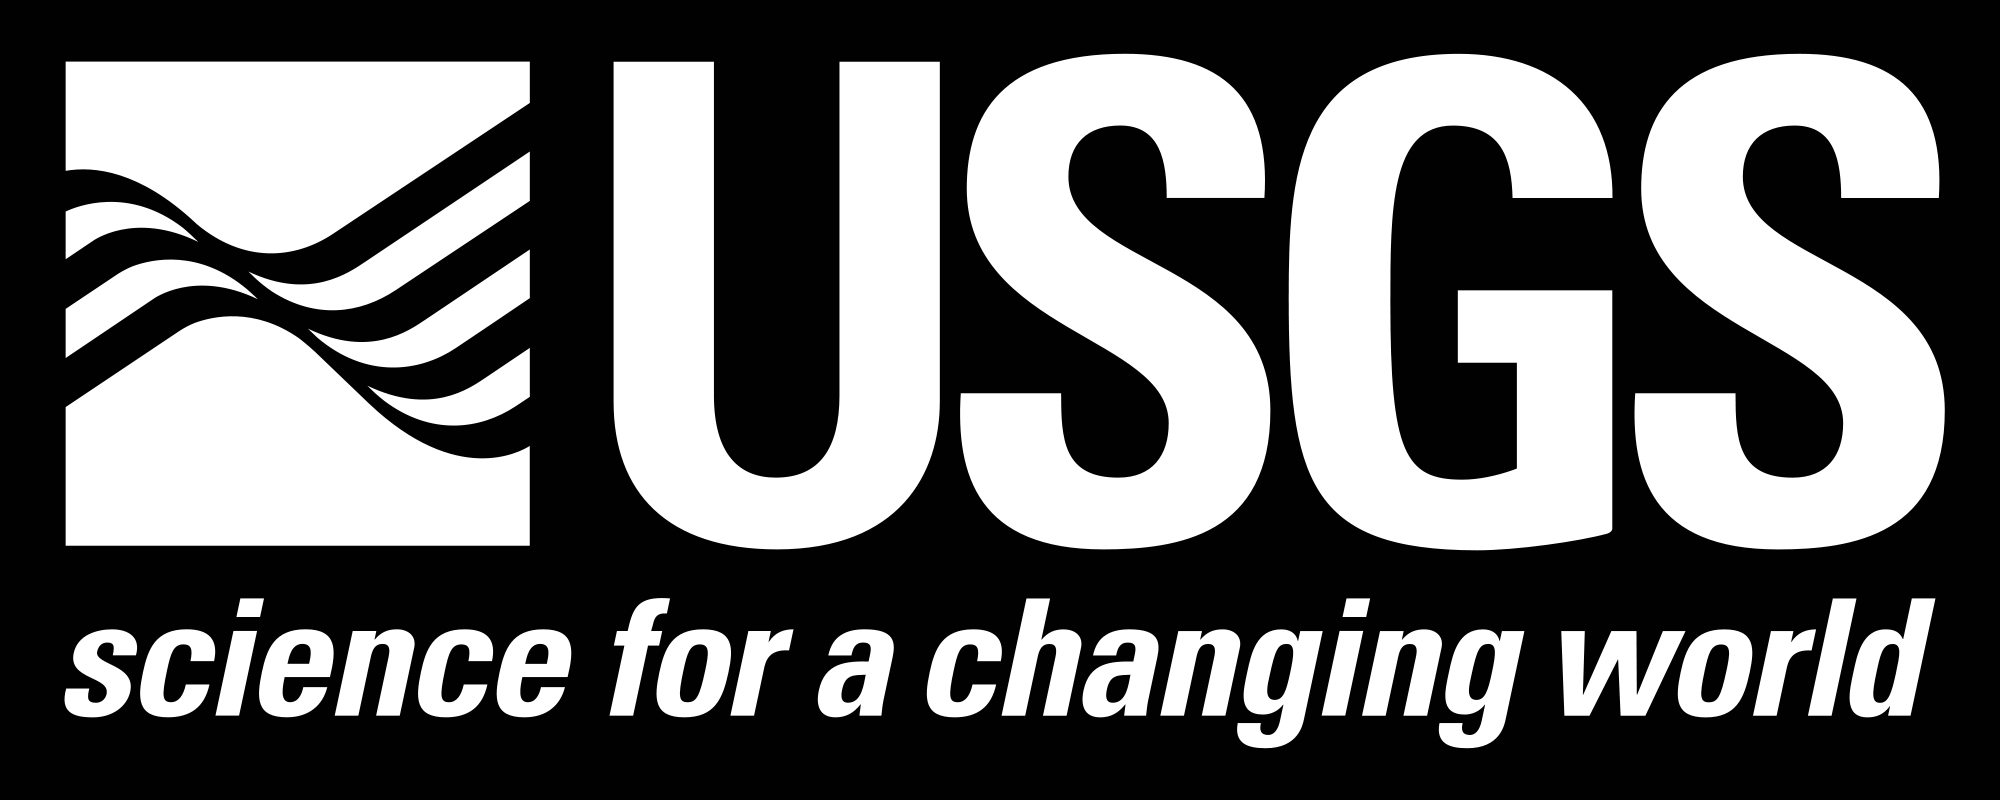

In [15]:
pn.Column(header, geo)

As before, we now have a functional dashboard that we can show with `.show()` or serve with `.servable()`.

## Final Dashboard

We can now put all the concepts we have learned together to make a more sophisticated, interactive dashboard supporting linked selections:

In [16]:
pn.state.template.sidebar_width = 250
pn.state.template.title = 'Earthquake Interactive Demo'

ls = hv.link_selections.instance(unselected_alpha=0.02)

# Table is not yet dynamically linked to the linked selection
table = filtered_subrange.pipe(ls.filter, selection_expr=ls.param.selection_expr)[['time', 'place', 'mag', 'depth']].pipe(
    pn.widgets.Tabulator, pagination='remote', page_size=15)

mag_hist = filtered_subrange.hvplot(
    y='mag', kind='hist', responsive=True, min_height=300)

depth_hist = filtered_subrange.hvplot(
    y='depth', kind='hist', responsive=True, min_height=300)

geo = filtered_subrange.hvplot(
    'easting', 'northing', color='mag', kind='points',
    xaxis=None, yaxis=None, responsive=True, min_height=500,
    data_aspect=1, framewise=True, clim=(4, 10), line_color='black'
)

column = pn.Column(
    pn.Row(
        hv.element.tiles.ESRI() * ls(geo.holoviews()),
        table.panel()
    ),
    pn.Row(
        ls(depth_hist.holoviews()),
        ls(mag_hist.holoviews()),
    )
)

In [17]:
filtered_subrange.widgets().servable(area='sidebar')

Column(sizing_mode='stretch_width')
    [0] FloatSlider(end=9, name='Magnitude', sizing_mode='stretch_width', start=3, value=3)
    [1] DateRangeSlider(end=Timestamp('2017-12-01 0..., name='Date', sizing_mode='stretch_width', start=Timestamp('2017-01-31 2..., value=(Timestamp('2017-01-31 23:..., value_end=Timestamp('2017-12-01 0..., value_start=Timestamp('2017-01-31 2...)

In [18]:
column.servable(title='Earthquake Interactive Demo')

Column(sizing_mode='stretch_width')
    [0] Row(sizing_mode='stretch_width')
        [0] HoloViews(DynamicMap, sizing_mode='stretch_width')
        [1] ParamFunction(function, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] HoloViews(DynamicMap, sizing_mode='stretch_width')
        [1] HoloViews(DynamicMap, sizing_mode='stretch_width')

This dashboard should work in the notebook interface (with widgets shown separately from the plots above) for debugging, but a complex layout like that is meant to be served separately, e.g. using `panel serve --port 5067 06_Dashboards.ipynb` run in this directory. If working with the `anaconda-project` version of this tutorial, you can run:

```bash
anaconda-project run dashboard
```

Note that the code above can instead be pasted into a Python text file and run with `panel serve file.py`; none of the machinery depends on Jupyter or on being stored in the notebook format, and apps can be developed fully in text editors if preferred.

# Conclusion

The techniques above and in the previous notebooks should enable you to build complex, deeply interlinked layouts and dashboards that help you understand your data and uncover hidden relationships, with custom interactivity for exploring any parameters of interest. You can explore further at the websites for any of the tools mentioned here, starting at [hvplot.holoviz.org](https://hvplot.holoviz.org) and moving on from there as needed.

In the tutorials so far, we have focused almost exclusively on the highest-level APIs provided by HoloViz, namely `.hvplot()` and `.interactive()`. These interfaces let you focus on the data you are trying to work with, without getting bogged down in writing dozens or hundreds of lines of plotting or callback code. Of course, they don't cover every possible type of plot or interactivity, and if you want full control, you'll need to learn the lower-level APIs provided by HoloViz tools (HoloViews and Panel), or the even lower-level tools, like Bokeh. The remaining tutorials are entirely optional, but they introduce some of those lower-level APIs so that you can see how to do things more manually when needed. These later tutorials are particularly useful for understanding the examples of interesting apps at [examples.pyviz.org](https://examples.pyviz.org), most of which were written before the simple `.interactive()` interface was developed.